In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# 1. 실험 결과가 저장된 경로 설정 (본인이 설정한 경로와 일치해야 함)
# 각 모델별로 가장 최근에 학습한 로그 파일을 자동으로 찾습니다.
checkpoints = {
    'CaliMatch (Ours)': './checkpoints_ecg',       # CaliMatch 저장 경로
    'FixMatch': './checkpoints_fixmatch',          # FixMatch 저장 경로
    'OpenMatch': './checkpoints_openmatch'         # OpenMatch 저장 경로
}

def parse_log_file(root_dir):
    """
    해당 디렉토리에서 가장 최신 main.log 파일을 찾아
    Best Accuracy와 그때의 ECE를 추출합니다.
    """
    # 1. main.log 파일 찾기 (하위 폴더 검색)
    log_files = glob.glob(f"{root_dir}/**/main.log", recursive=True)
    if not log_files:
        return None

    # 가장 최근에 수정된 로그 파일 선택
    latest_log = max(log_files, key=os.path.getmtime)

    best_acc = 0.0
    best_ece = 0.0
    final_acc = 0.0
    final_ece = 0.0

    try:
        with open(latest_log, 'r') as f:
            lines = f.readlines()

        # 로그 한 줄씩 읽으면서 'Best' 또는 'Test' 결과 파싱
        # (로그 형식: ... | test_top@1: 0.790 | ... | test_ece: 0.157 | ...)
        for line in lines:
            if "test_top@1" in line and "test_ece" in line:
                # 정규표현식으로 숫자 추출
                acc_match = re.search(r'test_top@1:\s*([\d\.]+)', line)
                ece_match = re.search(r'test_ece:\s*([\d\.]+)', line)

                if acc_match and ece_match:
                    acc = float(acc_match.group(1))
                    ece = float(ece_match.group(1))

                    # 마지막 에폭 값 저장
                    final_acc = acc
                    final_ece = ece

                    # Best Acc 갱신 (일반적으로 Best Val Acc일 때의 Test Acc를 기록하지만, 여기선 Max Test Acc로 근사)
                    if acc > best_acc:
                        best_acc = acc
                        best_ece = ece # Best Acc일 때의 ECE

        return {'ACC': best_acc * 100, 'ECE': best_ece} # 백분율(%)과 소수점 통일

    except Exception as e:
        print(f"Error parsing {latest_log}: {e}")
        return None

# 2. 데이터 모으기
results = []
for model_name, path in checkpoints.items():
    res = parse_log_file(path)
    if res:
        res['Model'] = model_name
        results.append(res)
    else:
        print(f"⚠️ {model_name}의 로그 파일을 찾을 수 없습니다. ({path})")

# 3. 결과 테이블 생성 (DataFrame)
if results:
    df = pd.DataFrame(results)
    df = df.set_index('Model')
    df = df[['ACC', 'ECE']] # 순서 정렬

    print("\n" + "="*40)
    print(" 📊 최종 성능 비교 평가 (Best Test Result)")
    print("="*40)
    print(df)
    print("="*40 + "\n")

    # 4. 시각화 (Bar Chart)
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # ACC (막대 그래프)
    color = 'tab:blue'
    ax1.set_xlabel('Model', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Accuracy (%)', color=color, fontsize=12, fontweight='bold')
    bars = ax1.bar(df.index, df['ACC'], color=color, alpha=0.6, label='Accuracy', width=0.4)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim(0, 100)

    # ECE (꺾은선 그래프) - 낮을수록 좋음
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('ECE (Lower is Better)', color=color, fontsize=12, fontweight='bold')
    line = ax2.plot(df.index, df['ECE'], color=color, marker='o', linewidth=3, markersize=10, label='ECE')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0, 0.3) # ECE 범위 조절

    # 값 표시
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', color='blue', fontweight='bold')

    for i, txt in enumerate(df['ECE']):
        ax2.text(i, txt + 0.01, f'{txt:.3f}', ha='center', va='bottom', color='red', fontweight='bold')

    plt.title('Comparison of Accuracy vs Calibration (ECE)', fontsize=14, fontweight='bold')
    fig.tight_layout()
    plt.show()

else:
    print("결과를 표시할 데이터가 없습니다. 경로를 확인해주세요.")

⚠️ CaliMatch (Ours)의 로그 파일을 찾을 수 없습니다. (./checkpoints_ecg)
⚠️ FixMatch의 로그 파일을 찾을 수 없습니다. (./checkpoints_fixmatch)
⚠️ OpenMatch의 로그 파일을 찾을 수 없습니다. (./checkpoints_openmatch)
결과를 표시할 데이터가 없습니다. 경로를 확인해주세요.


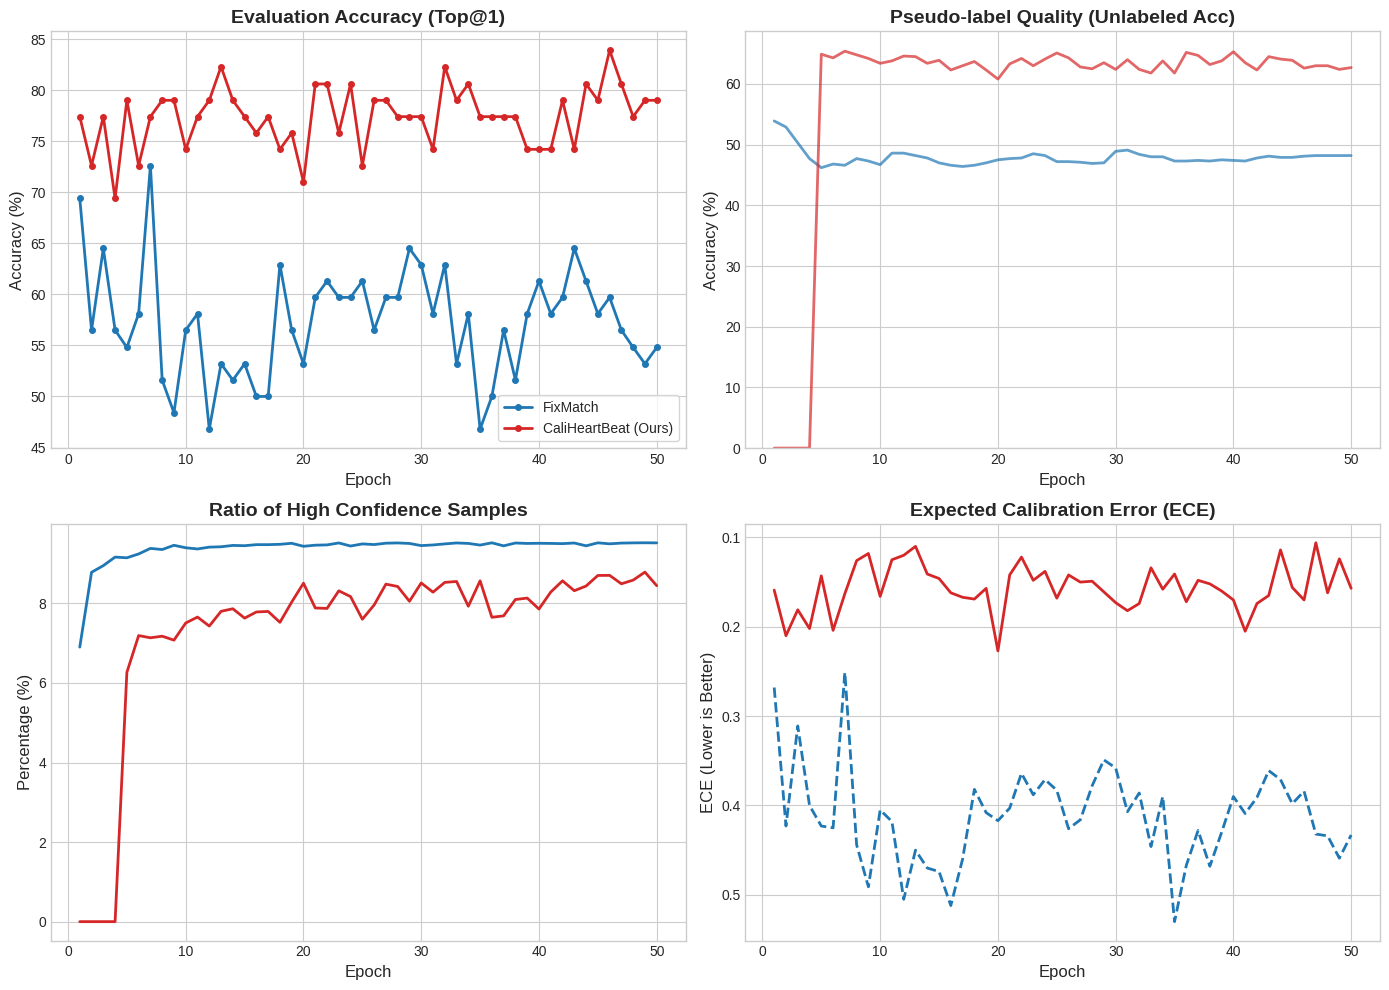

In [3]:
import re
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------------------------------------
# 1. 로그 데이터 입력 (제공해주신 텍스트 데이터를 그대로 사용)
# ---------------------------------------------------------

calimatch_log = """
[12/05/25 08:16:34] INFO Epoch: [ 1/50] ( 1) | eval_top@1: 0.774 | eval_ece: 0.159 | train_unlabeled_top@ 1: 0.000 | train_N_used_unlabeled: 0.000
[12/05/25 08:17:04] INFO Epoch: [ 2/50] ( 1) | eval_top@1: 0.726 | eval_ece: 0.210 | train_unlabeled_top@ 1: 0.000 | train_N_used_unlabeled: 0.000
[12/05/25 08:17:33] INFO Epoch: [ 3/50] ( 1) | eval_top@1: 0.774 | eval_ece: 0.181 | train_unlabeled_top@ 1: 0.000 | train_N_used_unlabeled: 0.000
[12/05/25 08:18:02] INFO Epoch: [ 4/50] ( 1) | eval_top@1: 0.694 | eval_ece: 0.202 | train_unlabeled_top@ 1: 0.000 | train_N_used_unlabeled: 0.000
[12/05/25 08:18:39] INFO Epoch: [ 5/50] ( 5) | eval_top@1: 0.790 | eval_ece: 0.143 | train_unlabeled_top@ 1: 0.649 | train_N_used_unlabeled: 21.051
[12/05/25 08:19:15] INFO Epoch: [ 6/50] ( 5) | eval_top@1: 0.726 | eval_ece: 0.204 | train_unlabeled_top@ 1: 0.643 | train_N_used_unlabeled: 24.161
[12/05/25 08:19:51] INFO Epoch: [ 7/50] ( 5) | eval_top@1: 0.774 | eval_ece: 0.163 | train_unlabeled_top@ 1: 0.654 | train_N_used_unlabeled: 23.974
[12/05/25 08:20:28] INFO Epoch: [ 8/50] ( 5) | eval_top@1: 0.790 | eval_ece: 0.126 | train_unlabeled_top@ 1: 0.648 | train_N_used_unlabeled: 24.108
[12/05/25 08:21:05] INFO Epoch: [ 9/50] ( 5) | eval_top@1: 0.790 | eval_ece: 0.118 | train_unlabeled_top@ 1: 0.642 | train_N_used_unlabeled: 23.775
[12/05/25 08:21:41] INFO Epoch: [10/50] ( 5) | eval_top@1: 0.742 | eval_ece: 0.166 | train_unlabeled_top@ 1: 0.634 | train_N_used_unlabeled: 25.224
[12/05/25 08:22:17] INFO Epoch: [11/50] ( 5) | eval_top@1: 0.774 | eval_ece: 0.125 | train_unlabeled_top@ 1: 0.638 | train_N_used_unlabeled: 25.724
[12/05/25 08:22:55] INFO Epoch: [12/50] ( 5) | eval_top@1: 0.790 | eval_ece: 0.120 | train_unlabeled_top@ 1: 0.646 | train_N_used_unlabeled: 24.964
[12/05/25 08:23:31] INFO Epoch: [13/50] (13) | eval_top@1: 0.823 | eval_ece: 0.110 | train_unlabeled_top@ 1: 0.645 | train_N_used_unlabeled: 26.209
[12/05/25 08:24:08] INFO Epoch: [14/50] (13) | eval_top@1: 0.790 | eval_ece: 0.141 | train_unlabeled_top@ 1: 0.634 | train_N_used_unlabeled: 26.427
[12/05/25 08:24:45] INFO Epoch: [15/50] (13) | eval_top@1: 0.774 | eval_ece: 0.146 | train_unlabeled_top@ 1: 0.639 | train_N_used_unlabeled: 25.634
[12/05/25 08:25:22] INFO Epoch: [16/50] (13) | eval_top@1: 0.758 | eval_ece: 0.162 | train_unlabeled_top@ 1: 0.623 | train_N_used_unlabeled: 26.155
[12/05/25 08:25:58] INFO Epoch: [17/50] (13) | eval_top@1: 0.774 | eval_ece: 0.167 | train_unlabeled_top@ 1: 0.630 | train_N_used_unlabeled: 26.199
[12/05/25 08:26:35] INFO Epoch: [18/50] (13) | eval_top@1: 0.742 | eval_ece: 0.169 | train_unlabeled_top@ 1: 0.637 | train_N_used_unlabeled: 25.279
[12/05/25 08:27:12] INFO Epoch: [19/50] (13) | eval_top@1: 0.758 | eval_ece: 0.157 | train_unlabeled_top@ 1: 0.623 | train_N_used_unlabeled: 26.992
[12/05/25 08:27:49] INFO Epoch: [20/50] (13) | eval_top@1: 0.710 | eval_ece: 0.227 | train_unlabeled_top@ 1: 0.608 | train_N_used_unlabeled: 28.586
[12/05/25 08:28:25] INFO Epoch: [21/50] (13) | eval_top@1: 0.806 | eval_ece: 0.142 | train_unlabeled_top@ 1: 0.633 | train_N_used_unlabeled: 26.493
[12/05/25 08:29:02] INFO Epoch: [22/50] (13) | eval_top@1: 0.806 | eval_ece: 0.122 | train_unlabeled_top@ 1: 0.642 | train_N_used_unlabeled: 26.454
[12/05/25 08:29:38] INFO Epoch: [23/50] (13) | eval_top@1: 0.758 | eval_ece: 0.148 | train_unlabeled_top@ 1: 0.630 | train_N_used_unlabeled: 27.942
[12/05/25 08:30:15] INFO Epoch: [24/50] (13) | eval_top@1: 0.806 | eval_ece: 0.138 | train_unlabeled_top@ 1: 0.641 | train_N_used_unlabeled: 27.451
[12/05/25 08:30:51] INFO Epoch: [25/50] (13) | eval_top@1: 0.726 | eval_ece: 0.168 | train_unlabeled_top@ 1: 0.651 | train_N_used_unlabeled: 25.541
[12/05/25 08:31:28] INFO Epoch: [26/50] (13) | eval_top@1: 0.790 | eval_ece: 0.142 | train_unlabeled_top@ 1: 0.643 | train_N_used_unlabeled: 26.746
[12/05/25 08:32:04] INFO Epoch: [27/50] (13) | eval_top@1: 0.790 | eval_ece: 0.150 | train_unlabeled_top@ 1: 0.628 | train_N_used_unlabeled: 28.505
[12/05/25 08:32:40] INFO Epoch: [28/50] (13) | eval_top@1: 0.774 | eval_ece: 0.149 | train_unlabeled_top@ 1: 0.625 | train_N_used_unlabeled: 28.307
[12/05/25 08:33:17] INFO Epoch: [29/50] (13) | eval_top@1: 0.774 | eval_ece: 0.161 | train_unlabeled_top@ 1: 0.635 | train_N_used_unlabeled: 27.059
[12/05/25 08:33:53] INFO Epoch: [30/50] (13) | eval_top@1: 0.774 | eval_ece: 0.173 | train_unlabeled_top@ 1: 0.624 | train_N_used_unlabeled: 28.605
[12/05/25 08:34:29] INFO Epoch: [31/50] (13) | eval_top@1: 0.742 | eval_ece: 0.182 | train_unlabeled_top@ 1: 0.640 | train_N_used_unlabeled: 27.828
[12/05/25 08:35:05] INFO Epoch: [32/50] (13) | eval_top@1: 0.823 | eval_ece: 0.174 | train_unlabeled_top@ 1: 0.624 | train_N_used_unlabeled: 28.653
[12/05/25 08:35:42] INFO Epoch: [33/50] (13) | eval_top@1: 0.790 | eval_ece: 0.134 | train_unlabeled_top@ 1: 0.618 | train_N_used_unlabeled: 28.731
[12/05/25 08:36:18] INFO Epoch: [34/50] (13) | eval_top@1: 0.806 | eval_ece: 0.158 | train_unlabeled_top@ 1: 0.638 | train_N_used_unlabeled: 26.641
[12/05/25 08:36:54] INFO Epoch: [35/50] (13) | eval_top@1: 0.774 | eval_ece: 0.141 | train_unlabeled_top@ 1: 0.618 | train_N_used_unlabeled: 28.786
[12/05/25 08:37:31] INFO Epoch: [36/50] (13) | eval_top@1: 0.774 | eval_ece: 0.172 | train_unlabeled_top@ 1: 0.652 | train_N_used_unlabeled: 25.705
[12/05/25 08:38:08] INFO Epoch: [37/50] (13) | eval_top@1: 0.774 | eval_ece: 0.148 | train_unlabeled_top@ 1: 0.647 | train_N_used_unlabeled: 25.828
[12/05/25 08:38:44] INFO Epoch: [38/50] (13) | eval_top@1: 0.774 | eval_ece: 0.152 | train_unlabeled_top@ 1: 0.632 | train_N_used_unlabeled: 27.207
[12/05/25 08:39:21] INFO Epoch: [39/50] (13) | eval_top@1: 0.742 | eval_ece: 0.160 | train_unlabeled_top@ 1: 0.638 | train_N_used_unlabeled: 27.328
[12/05/25 08:39:58] INFO Epoch: [40/50] (13) | eval_top@1: 0.742 | eval_ece: 0.170 | train_unlabeled_top@ 1: 0.653 | train_N_used_unlabeled: 26.403
[12/05/25 08:40:35] INFO Epoch: [41/50] (13) | eval_top@1: 0.742 | eval_ece: 0.205 | train_unlabeled_top@ 1: 0.635 | train_N_used_unlabeled: 27.838
[12/05/25 08:41:12] INFO Epoch: [42/50] (13) | eval_top@1: 0.790 | eval_ece: 0.174 | train_unlabeled_top@ 1: 0.623 | train_N_used_unlabeled: 28.786
[12/05/25 08:41:48] INFO Epoch: [43/50] (13) | eval_top@1: 0.742 | eval_ece: 0.165 | train_unlabeled_top@ 1: 0.645 | train_N_used_unlabeled: 27.949
[12/05/25 08:42:25] INFO Epoch: [44/50] (13) | eval_top@1: 0.806 | eval_ece: 0.114 | train_unlabeled_top@ 1: 0.641 | train_N_used_unlabeled: 28.345
[12/05/25 08:43:02] INFO Epoch: [45/50] (13) | eval_top@1: 0.790 | eval_ece: 0.156 | train_unlabeled_top@ 1: 0.639 | train_N_used_unlabeled: 29.238
[12/05/25 08:43:39] INFO Epoch: [46/50] (46) | eval_top@1: 0.839 | eval_ece: 0.170 | train_unlabeled_top@ 1: 0.626 | train_N_used_unlabeled: 29.247
[12/05/25 08:44:16] INFO Epoch: [47/50] (46) | eval_top@1: 0.806 | eval_ece: 0.106 | train_unlabeled_top@ 1: 0.630 | train_N_used_unlabeled: 28.534
[12/05/25 08:44:52] INFO Epoch: [48/50] (46) | eval_top@1: 0.774 | eval_ece: 0.162 | train_unlabeled_top@ 1: 0.630 | train_N_used_unlabeled: 28.846
[12/05/25 08:45:29] INFO Epoch: [49/50] (46) | eval_top@1: 0.790 | eval_ece: 0.124 | train_unlabeled_top@ 1: 0.624 | train_N_used_unlabeled: 29.522
[12/05/25 08:46:05] INFO Epoch: [50/50] (46) | eval_top@1: 0.790 | eval_ece: 0.157 | train_unlabeled_top@ 1: 0.627 | train_N_used_unlabeled: 28.374
"""

fixmatch_log = """
[12/06/25 08:30:32] INFO Epoch: [ 1/50] ( 1) | eval_top@1: 0.694 | eval_ece: 0.268 | train_unlabeled_top@ 1: 0.539 | train_N_used_unlabeled: 23.187
[12/06/25 08:30:58] INFO Epoch: [ 2/50] ( 1) | eval_top@1: 0.565 | eval_ece: 0.423 | train_unlabeled_top@ 1: 0.529 | train_N_used_unlabeled: 29.507
[12/06/25 08:31:24] INFO Epoch: [ 3/50] ( 1) | eval_top@1: 0.645 | eval_ece: 0.311 | train_unlabeled_top@ 1: 0.503 | train_N_used_unlabeled: 30.070
[12/06/25 08:31:51] INFO Epoch: [ 4/50] ( 1) | eval_top@1: 0.565 | eval_ece: 0.400 | train_unlabeled_top@ 1: 0.477 | train_N_used_unlabeled: 30.790
[12/06/25 08:32:17] INFO Epoch: [ 5/50] ( 1) | eval_top@1: 0.548 | eval_ece: 0.423 | train_unlabeled_top@ 1: 0.462 | train_N_used_unlabeled: 30.731
[12/06/25 08:32:44] INFO Epoch: [ 6/50] ( 1) | eval_top@1: 0.581 | eval_ece: 0.425 | train_unlabeled_top@ 1: 0.468 | train_N_used_unlabeled: 31.056
[12/06/25 08:33:11] INFO Epoch: [ 7/50] ( 7) | eval_top@1: 0.726 | eval_ece: 0.251 | train_unlabeled_top@ 1: 0.466 | train_N_used_unlabeled: 31.524
[12/06/25 08:33:38] INFO Epoch: [ 8/50] ( 7) | eval_top@1: 0.516 | eval_ece: 0.444 | train_unlabeled_top@ 1: 0.477 | train_N_used_unlabeled: 31.428
[12/06/25 08:34:04] INFO Epoch: [ 9/50] ( 7) | eval_top@1: 0.484 | eval_ece: 0.491 | train_unlabeled_top@ 1: 0.473 | train_N_used_unlabeled: 31.787
[12/06/25 08:34:31] INFO Epoch: [10/50] ( 7) | eval_top@1: 0.565 | eval_ece: 0.405 | train_unlabeled_top@ 1: 0.467 | train_N_used_unlabeled: 31.577
[12/06/25 08:34:57] INFO Epoch: [11/50] ( 7) | eval_top@1: 0.581 | eval_ece: 0.418 | train_unlabeled_top@ 1: 0.486 | train_N_used_unlabeled: 31.478
[12/06/25 08:35:23] INFO Epoch: [12/50] ( 7) | eval_top@1: 0.468 | eval_ece: 0.505 | train_unlabeled_top@ 1: 0.486 | train_N_used_unlabeled: 31.631
[12/06/25 08:35:50] INFO Epoch: [13/50] ( 7) | eval_top@1: 0.532 | eval_ece: 0.450 | train_unlabeled_top@ 1: 0.482 | train_N_used_unlabeled: 31.661
[12/06/25 08:36:17] INFO Epoch: [14/50] ( 7) | eval_top@1: 0.516 | eval_ece: 0.470 | train_unlabeled_top@ 1: 0.478 | train_N_used_unlabeled: 31.776
[12/06/25 08:36:43] INFO Epoch: [15/50] ( 7) | eval_top@1: 0.532 | eval_ece: 0.474 | train_unlabeled_top@ 1: 0.470 | train_N_used_unlabeled: 31.752
[12/06/25 08:37:10] INFO Epoch: [16/50] ( 7) | eval_top@1: 0.500 | eval_ece: 0.512 | train_unlabeled_top@ 1: 0.466 | train_N_used_unlabeled: 31.841
[12/06/25 08:37:36] INFO Epoch: [17/50] ( 7) | eval_top@1: 0.500 | eval_ece: 0.460 | train_unlabeled_top@ 1: 0.464 | train_N_used_unlabeled: 31.841
[12/06/25 08:38:03] INFO Epoch: [18/50] ( 7) | eval_top@1: 0.629 | eval_ece: 0.382 | train_unlabeled_top@ 1: 0.466 | train_N_used_unlabeled: 31.869
[12/06/25 08:38:30] INFO Epoch: [19/50] ( 7) | eval_top@1: 0.565 | eval_ece: 0.408 | train_unlabeled_top@ 1: 0.470 | train_N_used_unlabeled: 31.956
[12/06/25 08:38:56] INFO Epoch: [20/50] ( 7) | eval_top@1: 0.532 | eval_ece: 0.417 | train_unlabeled_top@ 1: 0.475 | train_N_used_unlabeled: 31.702
[12/06/25 08:39:23] INFO Epoch: [21/50] ( 7) | eval_top@1: 0.597 | eval_ece: 0.403 | train_unlabeled_top@ 1: 0.477 | train_N_used_unlabeled: 31.795
[12/06/25 08:39:49] INFO Epoch: [22/50] ( 7) | eval_top@1: 0.613 | eval_ece: 0.364 | train_unlabeled_top@ 1: 0.478 | train_N_used_unlabeled: 31.820
[12/06/25 08:40:16] INFO Epoch: [23/50] ( 7) | eval_top@1: 0.597 | eval_ece: 0.388 | train_unlabeled_top@ 1: 0.485 | train_N_used_unlabeled: 31.984
[12/06/25 08:40:43] INFO Epoch: [24/50] ( 7) | eval_top@1: 0.597 | eval_ece: 0.371 | train_unlabeled_top@ 1: 0.482 | train_N_used_unlabeled: 31.724
[12/06/25 08:41:09] INFO Epoch: [25/50] ( 7) | eval_top@1: 0.613 | eval_ece: 0.383 | train_unlabeled_top@ 1: 0.472 | train_N_used_unlabeled: 31.903
[12/06/25 08:41:36] INFO Epoch: [26/50] ( 7) | eval_top@1: 0.565 | eval_ece: 0.426 | train_unlabeled_top@ 1: 0.472 | train_N_used_unlabeled: 31.848
[12/06/25 08:42:02] INFO Epoch: [27/50] ( 7) | eval_top@1: 0.597 | eval_ece: 0.416 | train_unlabeled_top@ 1: 0.471 | train_N_used_unlabeled: 31.964
[12/06/25 08:42:29] INFO Epoch: [28/50] ( 7) | eval_top@1: 0.597 | eval_ece: 0.378 | train_unlabeled_top@ 1: 0.469 | train_N_used_unlabeled: 31.985
[12/06/25 08:42:55] INFO Epoch: [29/50] ( 7) | eval_top@1: 0.645 | eval_ece: 0.349 | train_unlabeled_top@ 1: 0.470 | train_N_used_unlabeled: 31.942
[12/06/25 08:43:22] INFO Epoch: [30/50] ( 7) | eval_top@1: 0.629 | eval_ece: 0.358 | train_unlabeled_top@ 1: 0.489 | train_N_used_unlabeled: 31.760
[12/06/25 08:43:49] INFO Epoch: [31/50] ( 7) | eval_top@1: 0.581 | eval_ece: 0.407 | train_unlabeled_top@ 1: 0.491 | train_N_used_unlabeled: 31.815
[12/06/25 08:44:15] INFO Epoch: [32/50] ( 7) | eval_top@1: 0.629 | eval_ece: 0.386 | train_unlabeled_top@ 1: 0.484 | train_N_used_unlabeled: 31.904
[12/06/25 08:44:42] INFO Epoch: [33/50] ( 7) | eval_top@1: 0.532 | eval_ece: 0.446 | train_unlabeled_top@ 1: 0.480 | train_N_used_unlabeled: 31.983
[12/06/25 08:45:09] INFO Epoch: [34/50] ( 7) | eval_top@1: 0.581 | eval_ece: 0.390 | train_unlabeled_top@ 1: 0.480 | train_N_used_unlabeled: 31.945
[12/06/25 08:45:36] INFO Epoch: [35/50] ( 7) | eval_top@1: 0.468 | eval_ece: 0.530 | train_unlabeled_top@ 1: 0.473 | train_N_used_unlabeled: 31.804
[12/06/25 08:46:02] INFO Epoch: [36/50] ( 7) | eval_top@1: 0.500 | eval_ece: 0.467 | train_unlabeled_top@ 1: 0.473 | train_N_used_unlabeled: 31.995
[12/06/25 08:46:29] INFO Epoch: [37/50] ( 7) | eval_top@1: 0.565 | eval_ece: 0.428 | train_unlabeled_top@ 1: 0.474 | train_N_used_unlabeled: 31.740
[12/06/25 08:46:56] INFO Epoch: [38/50] ( 7) | eval_top@1: 0.516 | eval_ece: 0.468 | train_unlabeled_top@ 1: 0.473 | train_N_used_unlabeled: 31.980
[12/06/25 08:47:22] INFO Epoch: [39/50] ( 7) | eval_top@1: 0.581 | eval_ece: 0.430 | train_unlabeled_top@ 1: 0.475 | train_N_used_unlabeled: 31.943
[12/06/25 08:47:49] INFO Epoch: [40/50] ( 7) | eval_top@1: 0.613 | eval_ece: 0.390 | train_unlabeled_top@ 1: 0.474 | train_N_used_unlabeled: 31.956
[12/06/25 08:48:16] INFO Epoch: [41/50] ( 7) | eval_top@1: 0.581 | eval_ece: 0.409 | train_unlabeled_top@ 1: 0.473 | train_N_used_unlabeled: 31.945
[12/06/25 08:48:43] INFO Epoch: [42/50] ( 7) | eval_top@1: 0.597 | eval_ece: 0.391 | train_unlabeled_top@ 1: 0.478 | train_N_used_unlabeled: 31.927
[12/06/25 08:49:10] INFO Epoch: [43/50] ( 7) | eval_top@1: 0.645 | eval_ece: 0.361 | train_unlabeled_top@ 1: 0.481 | train_N_used_unlabeled: 31.979
[12/06/25 08:49:36] INFO Epoch: [44/50] ( 7) | eval_top@1: 0.613 | eval_ece: 0.371 | train_unlabeled_top@ 1: 0.479 | train_N_used_unlabeled: 31.742
[12/06/25 08:50:03] INFO Epoch: [45/50] ( 7) | eval_top@1: 0.581 | eval_ece: 0.398 | train_unlabeled_top@ 1: 0.479 | train_N_used_unlabeled: 31.994
[12/06/25 08:50:30] INFO Epoch: [46/50] ( 7) | eval_top@1: 0.597 | eval_ece: 0.384 | train_unlabeled_top@ 1: 0.481 | train_N_used_unlabeled: 31.911
[12/06/25 08:50:56] INFO Epoch: [47/50] ( 7) | eval_top@1: 0.565 | eval_ece: 0.432 | train_unlabeled_top@ 1: 0.482 | train_N_used_unlabeled: 31.973
[12/06/25 08:51:23] INFO Epoch: [48/50] ( 7) | eval_top@1: 0.548 | eval_ece: 0.434 | train_unlabeled_top@ 1: 0.482 | train_N_used_unlabeled: 31.990
[12/06/25 08:51:50] INFO Epoch: [49/50] ( 7) | eval_top@1: 0.532 | eval_ece: 0.459 | train_unlabeled_top@ 1: 0.482 | train_N_used_unlabeled: 31.999
[12/06/25 08:52:17] INFO Epoch: [50/50] ( 7) | eval_top@1: 0.548 | eval_ece: 0.433 | train_unlabeled_top@ 1: 0.482 | train_N_used_unlabeled: 31.990
"""

# ---------------------------------------------------------
# 2. 데이터 파싱 함수 (Regex 활용)
# ---------------------------------------------------------
def parse_logs(log_text):
    epochs = []
    eval_top1 = []
    unlabeled_top1 = []
    ece = []
    n_used = []

    # 각 라인을 순회하며 데이터 추출
    lines = log_text.strip().split('\n')
    for line in lines:
        if "Epoch:" not in line: continue

        # Epoch
        ep_match = re.search(r"Epoch:\s*\[\s*(\d+)/", line)
        if ep_match: epochs.append(int(ep_match.group(1)))

        # Eval Top@1 (Validation Accuracy)
        # FixMatch 로그 등에서 test_top@1이 불규칙하므로 eval_top@1을 기준으로 비교
        acc_match = re.search(r"eval_top@1:\s*([\d.]+)", line)
        if acc_match: eval_top1.append(float(acc_match.group(1)) * 100) # 퍼센트로 변환

        # Unlabeled Top@1 (Pseudo-label Accuracy)
        # 로그 상 "train_unlabeled_top@ 1" 처럼 띄어쓰기가 있을 수 있음
        pseudo_match = re.search(r"train_unlabeled_top@\s*1:\s*([\d.]+)", line)
        if pseudo_match: unlabeled_top1.append(float(pseudo_match.group(1)) * 100)

        # ECE (Calibration Error)
        ece_match = re.search(r"eval_ece:\s*([\d.]+)", line)
        if ece_match: ece.append(float(ece_match.group(1)))

        # N Used (Utilization)
        n_match = re.search(r"train_N_used_unlabeled:\s*([\d.]+)", line)
        if n_match: n_used.append(float(n_match.group(1)))

    return epochs, eval_top1, unlabeled_top1, ece, n_used

# 데이터 파싱 실행
epochs_c, acc_c, pseudo_c, ece_c, used_c = parse_logs(calimatch_log)
epochs_f, acc_f, pseudo_f, ece_f, used_f = parse_logs(fixmatch_log)

# Unlabeled 데이터 총 개수 (로그 헤더에서 추출: 336개)
TOTAL_UNLABELED = 336
ratio_c = [n / TOTAL_UNLABELED * 100 for n in used_c]
ratio_f = [n / TOTAL_UNLABELED * 100 for n in used_f]

# ---------------------------------------------------------
# 3. 그래프 그리기 (논문 스타일)
# ---------------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid') # 깔끔한 그리드 스타일

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# 전체 타이틀은 생략하거나 논문 제목 등을 넣으세요

# 공통 설정
line_width = 2
marker_size = 4
color_proposed = '#d62728' # 빨간색 (CaliMatch - 제안 모델)
color_baseline = '#1f77b4' # 파란색 (FixMatch - 베이스라인)

# (1) Accuracy Plot
ax1 = axes[0, 0]
ax1.plot(epochs_f, acc_f, label='FixMatch', color=color_baseline, linewidth=line_width, marker='o', markersize=marker_size)
ax1.plot(epochs_c, acc_c, label='CaliHeartBeat (Ours)', color=color_proposed, linewidth=line_width, marker='o', markersize=marker_size)
ax1.set_title('Evaluation Accuracy (Top@1)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.legend(loc='best', frameon=True)

# (2) Pseudo-label Quality (Unlabeled Top@1)
ax2 = axes[0, 1]
ax2.plot(epochs_f, pseudo_f, label='FixMatch', color=color_baseline, linewidth=line_width, alpha=0.7)
ax2.plot(epochs_c, pseudo_c, label='CaliHeartBeat (Ours)', color=color_proposed, linewidth=line_width, alpha=0.7)
ax2.set_title('Pseudo-label Quality (Unlabeled Acc)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_xlabel('Epoch', fontsize=12)
# y축 범위가 0부터 시작하므로 약간 조정
ax2.set_ylim(bottom=0)

# (3) Utilization Ratio (Ratio of high confidence samples)
ax3 = axes[1, 0]
ax3.plot(epochs_f, ratio_f, label='FixMatch', color=color_baseline, linewidth=line_width)
ax3.plot(epochs_c, ratio_c, label='CaliHeartBeat (Ours)', color=color_proposed, linewidth=line_width)
ax3.set_title('Ratio of High Confidence Samples', fontsize=14, fontweight='bold')
ax3.set_ylabel('Percentage (%)', fontsize=12)
ax3.set_xlabel('Epoch', fontsize=12)
# ax3.set_ylim(0, 100) # 필요시 주석 해제

# (4) ECE (Calibration Error) - Reliability Diagram 대신 시계열 변화로 표현
ax4 = axes[1, 1]
ax4.plot(epochs_f, ece_f, label='FixMatch', color=color_baseline, linewidth=line_width, linestyle='--')
ax4.plot(epochs_c, ece_c, label='CaliHeartBeat (Ours)', color=color_proposed, linewidth=line_width, linestyle='-')
ax4.set_title('Expected Calibration Error (ECE)', fontsize=14, fontweight='bold')
ax4.set_ylabel('ECE (Lower is Better)', fontsize=12)
ax4.set_xlabel('Epoch', fontsize=12)
ax4.invert_yaxis() # ECE는 낮을수록 좋으므로 y축 반전 (선택 사항) 또는 그냥 둠

plt.tight_layout()
plt.show()

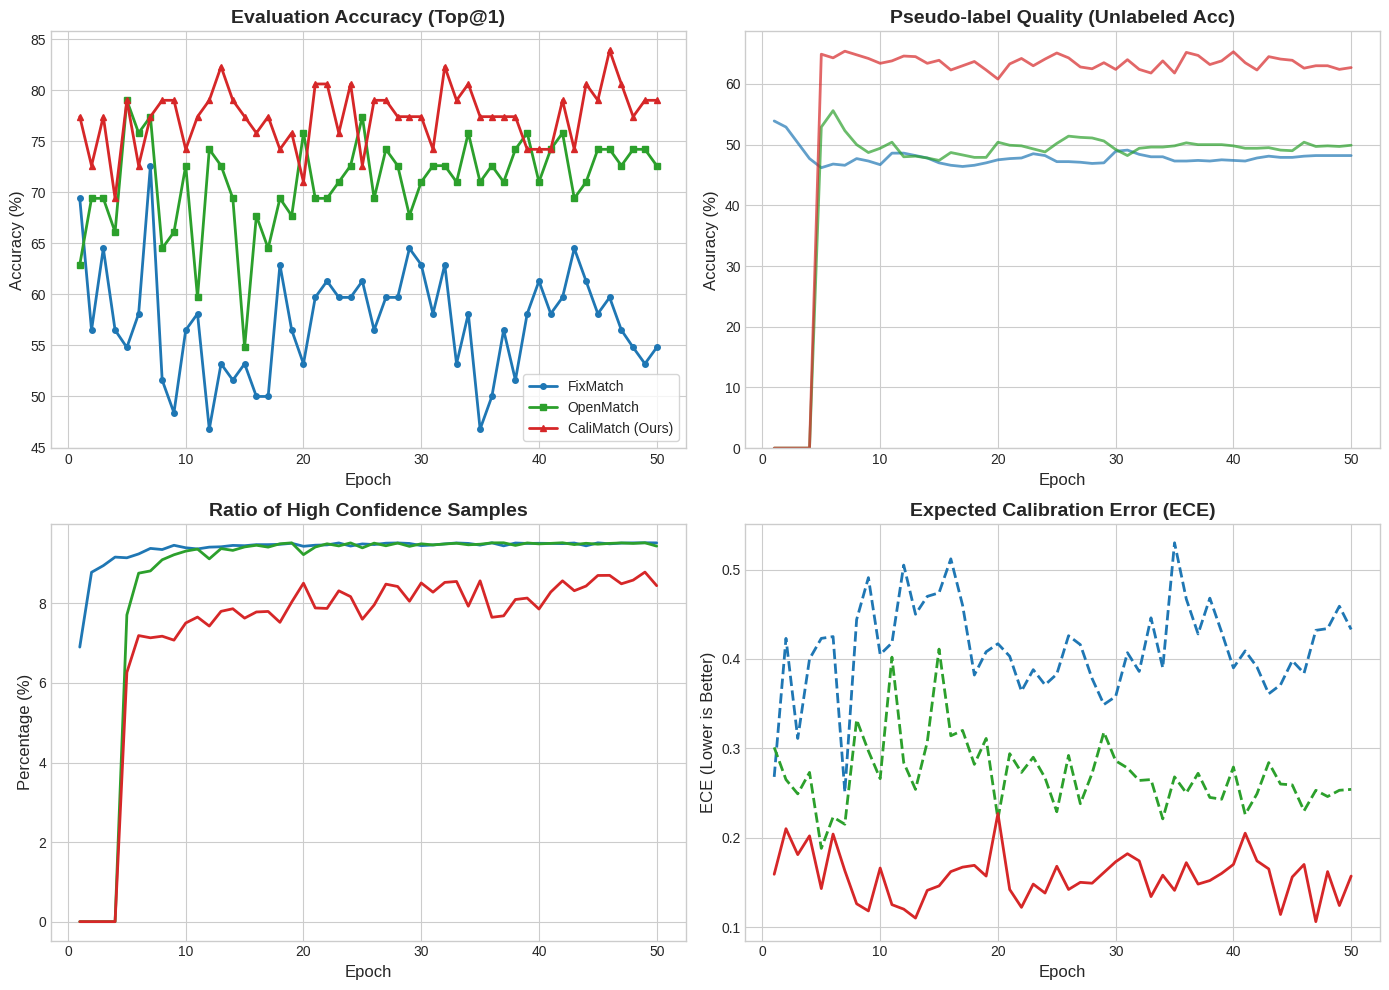

In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------------------------------------
# 1. 로그 데이터 입력
# ---------------------------------------------------------

# (1) FixMatch Log (이전 데이터)
fixmatch_log = """
[12/06/25 08:30:32] INFO Epoch: [ 1/50] ( 1) | eval_top@1: 0.694 | eval_ece: 0.268 | train_unlabeled_top@ 1: 0.539 | train_N_used_unlabeled: 23.187
[12/06/25 08:30:58] INFO Epoch: [ 2/50] ( 1) | eval_top@1: 0.565 | eval_ece: 0.423 | train_unlabeled_top@ 1: 0.529 | train_N_used_unlabeled: 29.507
[12/06/25 08:31:24] INFO Epoch: [ 3/50] ( 1) | eval_top@1: 0.645 | eval_ece: 0.311 | train_unlabeled_top@ 1: 0.503 | train_N_used_unlabeled: 30.070
[12/06/25 08:31:51] INFO Epoch: [ 4/50] ( 1) | eval_top@1: 0.565 | eval_ece: 0.400 | train_unlabeled_top@ 1: 0.477 | train_N_used_unlabeled: 30.790
[12/06/25 08:32:17] INFO Epoch: [ 5/50] ( 1) | eval_top@1: 0.548 | eval_ece: 0.423 | train_unlabeled_top@ 1: 0.462 | train_N_used_unlabeled: 30.731
[12/06/25 08:32:44] INFO Epoch: [ 6/50] ( 1) | eval_top@1: 0.581 | eval_ece: 0.425 | train_unlabeled_top@ 1: 0.468 | train_N_used_unlabeled: 31.056
[12/06/25 08:33:11] INFO Epoch: [ 7/50] ( 7) | eval_top@1: 0.726 | eval_ece: 0.251 | train_unlabeled_top@ 1: 0.466 | train_N_used_unlabeled: 31.524
[12/06/25 08:33:38] INFO Epoch: [ 8/50] ( 7) | eval_top@1: 0.516 | eval_ece: 0.444 | train_unlabeled_top@ 1: 0.477 | train_N_used_unlabeled: 31.428
[12/06/25 08:34:04] INFO Epoch: [ 9/50] ( 7) | eval_top@1: 0.484 | eval_ece: 0.491 | train_unlabeled_top@ 1: 0.473 | train_N_used_unlabeled: 31.787
[12/06/25 08:34:31] INFO Epoch: [10/50] ( 7) | eval_top@1: 0.565 | eval_ece: 0.405 | train_unlabeled_top@ 1: 0.467 | train_N_used_unlabeled: 31.577
[12/06/25 08:34:57] INFO Epoch: [11/50] ( 7) | eval_top@1: 0.581 | eval_ece: 0.418 | train_unlabeled_top@ 1: 0.486 | train_N_used_unlabeled: 31.478
[12/06/25 08:35:23] INFO Epoch: [12/50] ( 7) | eval_top@1: 0.468 | eval_ece: 0.505 | train_unlabeled_top@ 1: 0.486 | train_N_used_unlabeled: 31.631
[12/06/25 08:35:50] INFO Epoch: [13/50] ( 7) | eval_top@1: 0.532 | eval_ece: 0.450 | train_unlabeled_top@ 1: 0.482 | train_N_used_unlabeled: 31.661
[12/06/25 08:36:17] INFO Epoch: [14/50] ( 7) | eval_top@1: 0.516 | eval_ece: 0.470 | train_unlabeled_top@ 1: 0.478 | train_N_used_unlabeled: 31.776
[12/06/25 08:36:43] INFO Epoch: [15/50] ( 7) | eval_top@1: 0.532 | eval_ece: 0.474 | train_unlabeled_top@ 1: 0.470 | train_N_used_unlabeled: 31.752
[12/06/25 08:37:10] INFO Epoch: [16/50] ( 7) | eval_top@1: 0.500 | eval_ece: 0.512 | train_unlabeled_top@ 1: 0.466 | train_N_used_unlabeled: 31.841
[12/06/25 08:37:36] INFO Epoch: [17/50] ( 7) | eval_top@1: 0.500 | eval_ece: 0.460 | train_unlabeled_top@ 1: 0.464 | train_N_used_unlabeled: 31.841
[12/06/25 08:38:03] INFO Epoch: [18/50] ( 7) | eval_top@1: 0.629 | eval_ece: 0.382 | train_unlabeled_top@ 1: 0.466 | train_N_used_unlabeled: 31.869
[12/06/25 08:38:30] INFO Epoch: [19/50] ( 7) | eval_top@1: 0.565 | eval_ece: 0.408 | train_unlabeled_top@ 1: 0.470 | train_N_used_unlabeled: 31.956
[12/06/25 08:38:56] INFO Epoch: [20/50] ( 7) | eval_top@1: 0.532 | eval_ece: 0.417 | train_unlabeled_top@ 1: 0.475 | train_N_used_unlabeled: 31.702
[12/06/25 08:39:23] INFO Epoch: [21/50] ( 7) | eval_top@1: 0.597 | eval_ece: 0.403 | train_unlabeled_top@ 1: 0.477 | train_N_used_unlabeled: 31.795
[12/06/25 08:39:49] INFO Epoch: [22/50] ( 7) | eval_top@1: 0.613 | eval_ece: 0.364 | train_unlabeled_top@ 1: 0.478 | train_N_used_unlabeled: 31.820
[12/06/25 08:40:16] INFO Epoch: [23/50] ( 7) | eval_top@1: 0.597 | eval_ece: 0.388 | train_unlabeled_top@ 1: 0.485 | train_N_used_unlabeled: 31.984
[12/06/25 08:40:43] INFO Epoch: [24/50] ( 7) | eval_top@1: 0.597 | eval_ece: 0.371 | train_unlabeled_top@ 1: 0.482 | train_N_used_unlabeled: 31.724
[12/06/25 08:41:09] INFO Epoch: [25/50] ( 7) | eval_top@1: 0.613 | eval_ece: 0.383 | train_unlabeled_top@ 1: 0.472 | train_N_used_unlabeled: 31.903
[12/06/25 08:41:36] INFO Epoch: [26/50] ( 7) | eval_top@1: 0.565 | eval_ece: 0.426 | train_unlabeled_top@ 1: 0.472 | train_N_used_unlabeled: 31.848
[12/06/25 08:42:02] INFO Epoch: [27/50] ( 7) | eval_top@1: 0.597 | eval_ece: 0.416 | train_unlabeled_top@ 1: 0.471 | train_N_used_unlabeled: 31.964
[12/06/25 08:42:29] INFO Epoch: [28/50] ( 7) | eval_top@1: 0.597 | eval_ece: 0.378 | train_unlabeled_top@ 1: 0.469 | train_N_used_unlabeled: 31.985
[12/06/25 08:42:55] INFO Epoch: [29/50] ( 7) | eval_top@1: 0.645 | eval_ece: 0.349 | train_unlabeled_top@ 1: 0.470 | train_N_used_unlabeled: 31.942
[12/06/25 08:43:22] INFO Epoch: [30/50] ( 7) | eval_top@1: 0.629 | eval_ece: 0.358 | train_unlabeled_top@ 1: 0.489 | train_N_used_unlabeled: 31.760
[12/06/25 08:43:49] INFO Epoch: [31/50] ( 7) | eval_top@1: 0.581 | eval_ece: 0.407 | train_unlabeled_top@ 1: 0.491 | train_N_used_unlabeled: 31.815
[12/06/25 08:44:15] INFO Epoch: [32/50] ( 7) | eval_top@1: 0.629 | eval_ece: 0.386 | train_unlabeled_top@ 1: 0.484 | train_N_used_unlabeled: 31.904
[12/06/25 08:44:42] INFO Epoch: [33/50] ( 7) | eval_top@1: 0.532 | eval_ece: 0.446 | train_unlabeled_top@ 1: 0.480 | train_N_used_unlabeled: 31.983
[12/06/25 08:45:09] INFO Epoch: [34/50] ( 7) | eval_top@1: 0.581 | eval_ece: 0.390 | train_unlabeled_top@ 1: 0.480 | train_N_used_unlabeled: 31.945
[12/06/25 08:45:36] INFO Epoch: [35/50] ( 7) | eval_top@1: 0.468 | eval_ece: 0.530 | train_unlabeled_top@ 1: 0.473 | train_N_used_unlabeled: 31.804
[12/06/25 08:46:02] INFO Epoch: [36/50] ( 7) | eval_top@1: 0.500 | eval_ece: 0.467 | train_unlabeled_top@ 1: 0.473 | train_N_used_unlabeled: 31.995
[12/06/25 08:46:29] INFO Epoch: [37/50] ( 7) | eval_top@1: 0.565 | eval_ece: 0.428 | train_unlabeled_top@ 1: 0.474 | train_N_used_unlabeled: 31.740
[12/06/25 08:46:56] INFO Epoch: [38/50] ( 7) | eval_top@1: 0.516 | eval_ece: 0.468 | train_unlabeled_top@ 1: 0.473 | train_N_used_unlabeled: 31.980
[12/06/25 08:47:22] INFO Epoch: [39/50] ( 7) | eval_top@1: 0.581 | eval_ece: 0.430 | train_unlabeled_top@ 1: 0.475 | train_N_used_unlabeled: 31.943
[12/06/25 08:47:49] INFO Epoch: [40/50] ( 7) | eval_top@1: 0.613 | eval_ece: 0.390 | train_unlabeled_top@ 1: 0.474 | train_N_used_unlabeled: 31.956
[12/06/25 08:48:16] INFO Epoch: [41/50] ( 7) | eval_top@1: 0.581 | eval_ece: 0.409 | train_unlabeled_top@ 1: 0.473 | train_N_used_unlabeled: 31.945
[12/06/25 08:48:43] INFO Epoch: [42/50] ( 7) | eval_top@1: 0.597 | eval_ece: 0.391 | train_unlabeled_top@ 1: 0.478 | train_N_used_unlabeled: 31.927
[12/06/25 08:49:10] INFO Epoch: [43/50] ( 7) | eval_top@1: 0.645 | eval_ece: 0.361 | train_unlabeled_top@ 1: 0.481 | train_N_used_unlabeled: 31.979
[12/06/25 08:49:36] INFO Epoch: [44/50] ( 7) | eval_top@1: 0.613 | eval_ece: 0.371 | train_unlabeled_top@ 1: 0.479 | train_N_used_unlabeled: 31.742
[12/06/25 08:50:03] INFO Epoch: [45/50] ( 7) | eval_top@1: 0.581 | eval_ece: 0.398 | train_unlabeled_top@ 1: 0.479 | train_N_used_unlabeled: 31.994
[12/06/25 08:50:30] INFO Epoch: [46/50] ( 7) | eval_top@1: 0.597 | eval_ece: 0.384 | train_unlabeled_top@ 1: 0.481 | train_N_used_unlabeled: 31.911
[12/06/25 08:50:56] INFO Epoch: [47/50] ( 7) | eval_top@1: 0.565 | eval_ece: 0.432 | train_unlabeled_top@ 1: 0.482 | train_N_used_unlabeled: 31.973
[12/06/25 08:51:23] INFO Epoch: [48/50] ( 7) | eval_top@1: 0.548 | eval_ece: 0.434 | train_unlabeled_top@ 1: 0.482 | train_N_used_unlabeled: 31.990
[12/06/25 08:51:50] INFO Epoch: [49/50] ( 7) | eval_top@1: 0.532 | eval_ece: 0.459 | train_unlabeled_top@ 1: 0.482 | train_N_used_unlabeled: 31.999
[12/06/25 08:52:17] INFO Epoch: [50/50] ( 7) | eval_top@1: 0.548 | eval_ece: 0.433 | train_unlabeled_top@ 1: 0.482 | train_N_used_unlabeled: 31.990
"""

# (2) CaliMatch Log (제안 모델 - 이전 데이터)
calimatch_log = """
[12/05/25 08:16:34] INFO Epoch: [ 1/50] ( 1) | eval_top@1: 0.774 | eval_ece: 0.159 | train_unlabeled_top@ 1: 0.000 | train_N_used_unlabeled: 0.000
[12/05/25 08:17:04] INFO Epoch: [ 2/50] ( 1) | eval_top@1: 0.726 | eval_ece: 0.210 | train_unlabeled_top@ 1: 0.000 | train_N_used_unlabeled: 0.000
[12/05/25 08:17:33] INFO Epoch: [ 3/50] ( 1) | eval_top@1: 0.774 | eval_ece: 0.181 | train_unlabeled_top@ 1: 0.000 | train_N_used_unlabeled: 0.000
[12/05/25 08:18:02] INFO Epoch: [ 4/50] ( 1) | eval_top@1: 0.694 | eval_ece: 0.202 | train_unlabeled_top@ 1: 0.000 | train_N_used_unlabeled: 0.000
[12/05/25 08:18:39] INFO Epoch: [ 5/50] ( 5) | eval_top@1: 0.790 | eval_ece: 0.143 | train_unlabeled_top@ 1: 0.649 | train_N_used_unlabeled: 21.051
[12/05/25 08:19:15] INFO Epoch: [ 6/50] ( 5) | eval_top@1: 0.726 | eval_ece: 0.204 | train_unlabeled_top@ 1: 0.643 | train_N_used_unlabeled: 24.161
[12/05/25 08:19:51] INFO Epoch: [ 7/50] ( 5) | eval_top@1: 0.774 | eval_ece: 0.163 | train_unlabeled_top@ 1: 0.654 | train_N_used_unlabeled: 23.974
[12/05/25 08:20:28] INFO Epoch: [ 8/50] ( 5) | eval_top@1: 0.790 | eval_ece: 0.126 | train_unlabeled_top@ 1: 0.648 | train_N_used_unlabeled: 24.108
[12/05/25 08:21:05] INFO Epoch: [ 9/50] ( 5) | eval_top@1: 0.790 | eval_ece: 0.118 | train_unlabeled_top@ 1: 0.642 | train_N_used_unlabeled: 23.775
[12/05/25 08:21:41] INFO Epoch: [10/50] ( 5) | eval_top@1: 0.742 | eval_ece: 0.166 | train_unlabeled_top@ 1: 0.634 | train_N_used_unlabeled: 25.224
[12/05/25 08:22:17] INFO Epoch: [11/50] ( 5) | eval_top@1: 0.774 | eval_ece: 0.125 | train_unlabeled_top@ 1: 0.638 | train_N_used_unlabeled: 25.724
[12/05/25 08:22:55] INFO Epoch: [12/50] ( 5) | eval_top@1: 0.790 | eval_ece: 0.120 | train_unlabeled_top@ 1: 0.646 | train_N_used_unlabeled: 24.964
[12/05/25 08:23:31] INFO Epoch: [13/50] (13) | eval_top@1: 0.823 | eval_ece: 0.110 | train_unlabeled_top@ 1: 0.645 | train_N_used_unlabeled: 26.209
[12/05/25 08:24:08] INFO Epoch: [14/50] (13) | eval_top@1: 0.790 | eval_ece: 0.141 | train_unlabeled_top@ 1: 0.634 | train_N_used_unlabeled: 26.427
[12/05/25 08:24:45] INFO Epoch: [15/50] (13) | eval_top@1: 0.774 | eval_ece: 0.146 | train_unlabeled_top@ 1: 0.639 | train_N_used_unlabeled: 25.634
[12/05/25 08:25:22] INFO Epoch: [16/50] (13) | eval_top@1: 0.758 | eval_ece: 0.162 | train_unlabeled_top@ 1: 0.623 | train_N_used_unlabeled: 26.155
[12/05/25 08:25:58] INFO Epoch: [17/50] (13) | eval_top@1: 0.774 | eval_ece: 0.167 | train_unlabeled_top@ 1: 0.630 | train_N_used_unlabeled: 26.199
[12/05/25 08:26:35] INFO Epoch: [18/50] (13) | eval_top@1: 0.742 | eval_ece: 0.169 | train_unlabeled_top@ 1: 0.637 | train_N_used_unlabeled: 25.279
[12/05/25 08:27:12] INFO Epoch: [19/50] (13) | eval_top@1: 0.758 | eval_ece: 0.157 | train_unlabeled_top@ 1: 0.623 | train_N_used_unlabeled: 26.992
[12/05/25 08:27:49] INFO Epoch: [20/50] (13) | eval_top@1: 0.710 | eval_ece: 0.227 | train_unlabeled_top@ 1: 0.608 | train_N_used_unlabeled: 28.586
[12/05/25 08:28:25] INFO Epoch: [21/50] (13) | eval_top@1: 0.806 | eval_ece: 0.142 | train_unlabeled_top@ 1: 0.633 | train_N_used_unlabeled: 26.493
[12/05/25 08:29:02] INFO Epoch: [22/50] (13) | eval_top@1: 0.806 | eval_ece: 0.122 | train_unlabeled_top@ 1: 0.642 | train_N_used_unlabeled: 26.454
[12/05/25 08:29:38] INFO Epoch: [23/50] (13) | eval_top@1: 0.758 | eval_ece: 0.148 | train_unlabeled_top@ 1: 0.630 | train_N_used_unlabeled: 27.942
[12/05/25 08:30:15] INFO Epoch: [24/50] (13) | eval_top@1: 0.806 | eval_ece: 0.138 | train_unlabeled_top@ 1: 0.641 | train_N_used_unlabeled: 27.451
[12/05/25 08:30:51] INFO Epoch: [25/50] (13) | eval_top@1: 0.726 | eval_ece: 0.168 | train_unlabeled_top@ 1: 0.651 | train_N_used_unlabeled: 25.541
[12/05/25 08:31:28] INFO Epoch: [26/50] (13) | eval_top@1: 0.790 | eval_ece: 0.142 | train_unlabeled_top@ 1: 0.643 | train_N_used_unlabeled: 26.746
[12/05/25 08:32:04] INFO Epoch: [27/50] (13) | eval_top@1: 0.790 | eval_ece: 0.150 | train_unlabeled_top@ 1: 0.628 | train_N_used_unlabeled: 28.505
[12/05/25 08:32:40] INFO Epoch: [28/50] (13) | eval_top@1: 0.774 | eval_ece: 0.149 | train_unlabeled_top@ 1: 0.625 | train_N_used_unlabeled: 28.307
[12/05/25 08:33:17] INFO Epoch: [29/50] (13) | eval_top@1: 0.774 | eval_ece: 0.161 | train_unlabeled_top@ 1: 0.635 | train_N_used_unlabeled: 27.059
[12/05/25 08:33:53] INFO Epoch: [30/50] (13) | eval_top@1: 0.774 | eval_ece: 0.173 | train_unlabeled_top@ 1: 0.624 | train_N_used_unlabeled: 28.605
[12/05/25 08:34:29] INFO Epoch: [31/50] (13) | eval_top@1: 0.742 | eval_ece: 0.182 | train_unlabeled_top@ 1: 0.640 | train_N_used_unlabeled: 27.828
[12/05/25 08:35:05] INFO Epoch: [32/50] (13) | eval_top@1: 0.823 | eval_ece: 0.174 | train_unlabeled_top@ 1: 0.624 | train_N_used_unlabeled: 28.653
[12/05/25 08:35:42] INFO Epoch: [33/50] (13) | eval_top@1: 0.790 | eval_ece: 0.134 | train_unlabeled_top@ 1: 0.618 | train_N_used_unlabeled: 28.731
[12/05/25 08:36:18] INFO Epoch: [34/50] (13) | eval_top@1: 0.806 | eval_ece: 0.158 | train_unlabeled_top@ 1: 0.638 | train_N_used_unlabeled: 26.641
[12/05/25 08:36:54] INFO Epoch: [35/50] (13) | eval_top@1: 0.774 | eval_ece: 0.141 | train_unlabeled_top@ 1: 0.618 | train_N_used_unlabeled: 28.786
[12/05/25 08:37:31] INFO Epoch: [36/50] (13) | eval_top@1: 0.774 | eval_ece: 0.172 | train_unlabeled_top@ 1: 0.652 | train_N_used_unlabeled: 25.705
[12/05/25 08:38:08] INFO Epoch: [37/50] (13) | eval_top@1: 0.774 | eval_ece: 0.148 | train_unlabeled_top@ 1: 0.647 | train_N_used_unlabeled: 25.828
[12/05/25 08:38:44] INFO Epoch: [38/50] (13) | eval_top@1: 0.774 | eval_ece: 0.152 | train_unlabeled_top@ 1: 0.632 | train_N_used_unlabeled: 27.207
[12/05/25 08:39:21] INFO Epoch: [39/50] (13) | eval_top@1: 0.742 | eval_ece: 0.160 | train_unlabeled_top@ 1: 0.638 | train_N_used_unlabeled: 27.328
[12/05/25 08:39:58] INFO Epoch: [40/50] (13) | eval_top@1: 0.742 | eval_ece: 0.170 | train_unlabeled_top@ 1: 0.653 | train_N_used_unlabeled: 26.403
[12/05/25 08:40:35] INFO Epoch: [41/50] (13) | eval_top@1: 0.742 | eval_ece: 0.205 | train_unlabeled_top@ 1: 0.635 | train_N_used_unlabeled: 27.838
[12/05/25 08:41:12] INFO Epoch: [42/50] (13) | eval_top@1: 0.790 | eval_ece: 0.174 | train_unlabeled_top@ 1: 0.623 | train_N_used_unlabeled: 28.786
[12/05/25 08:41:48] INFO Epoch: [43/50] (13) | eval_top@1: 0.742 | eval_ece: 0.165 | train_unlabeled_top@ 1: 0.645 | train_N_used_unlabeled: 27.949
[12/05/25 08:42:25] INFO Epoch: [44/50] (13) | eval_top@1: 0.806 | eval_ece: 0.114 | train_unlabeled_top@ 1: 0.641 | train_N_used_unlabeled: 28.345
[12/05/25 08:43:02] INFO Epoch: [45/50] (13) | eval_top@1: 0.790 | eval_ece: 0.156 | train_unlabeled_top@ 1: 0.639 | train_N_used_unlabeled: 29.238
[12/05/25 08:43:39] INFO Epoch: [46/50] (46) | eval_top@1: 0.839 | eval_ece: 0.170 | train_unlabeled_top@ 1: 0.626 | train_N_used_unlabeled: 29.247
[12/05/25 08:44:16] INFO Epoch: [47/50] (46) | eval_top@1: 0.806 | eval_ece: 0.106 | train_unlabeled_top@ 1: 0.630 | train_N_used_unlabeled: 28.534
[12/05/25 08:44:52] INFO Epoch: [48/50] (46) | eval_top@1: 0.774 | eval_ece: 0.162 | train_unlabeled_top@ 1: 0.630 | train_N_used_unlabeled: 28.846
[12/05/25 08:45:29] INFO Epoch: [49/50] (46) | eval_top@1: 0.790 | eval_ece: 0.124 | train_unlabeled_top@ 1: 0.624 | train_N_used_unlabeled: 29.522
[12/05/25 08:46:05] INFO Epoch: [50/50] (46) | eval_top@1: 0.790 | eval_ece: 0.157 | train_unlabeled_top@ 1: 0.627 | train_N_used_unlabeled: 28.374
"""

# (3) OpenMatch Log (새로 추가된 데이터)
openmatch_log = """
[12/07/25 07:09:35] INFO Epoch: [ 1/50] ( classification_OPENMATCH.py:222 1) | train_loss: 0.131 | eval_loss: 2.255 | test_loss: 1.775 | train_top@1: 0.986 | eval_top@1: 0.629 | test_top@1: 0.710 | train_ece: 0.014 | eval_ece: 0.301 | test_ece: 0.274 | train_unlabeled_top @1: 0.000 | train_unlabeled_ece : 0.000 | train_N_used_unlabe led: 0.000 |
[12/07/25 07:10:09] INFO Epoch: [ 2/50] ( classification_OPENMATCH.py:222 2) | train_loss: 0.049 | eval_loss: 1.774 | test_loss: 1.780 | train_top@1: 0.997 | eval_top@1: 0.694 | test_top@1: 0.661 | train_ece: 0.004 | eval_ece: 0.265 | test_ece: 0.280 | train_unlabeled_top @1: 0.000 | train_unlabeled_ece : 0.000 | train_N_used_unlabe led: 0.000 |
[12/07/25 07:10:43] INFO Epoch: [ 3/50] ( classification_OPENMATCH.py:222 2) | train_loss: 0.028 | eval_loss: 2.203 | train_top@1: 0.999 | eval_top@1: 0.694 | train_ece: 0.002 | eval_ece: 0.249 | train_unlabeled_top @1: 0.000 | train_unlabeled_ece : 0.000 | train_N_used_unlabe led: 0.000 |
[12/07/25 07:11:17] INFO Epoch: [ 4/50] ( classification_OPENMATCH.py:222 2) | train_loss: 0.028 | eval_loss: 1.837 | train_top@1: 0.998 | eval_top@1: 0.661 | train_ece: 0.002 | eval_ece: 0.273 | train_unlabeled_top @1: 0.000 | train_unlabeled_ece : 0.000 | train_N_used_unlabe led: 0.000 |
[12/07/25 07:12:03] INFO Epoch: [ 5/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.143 | eval_loss: 1.508 | test_loss: 2.306 | train_top@1: 0.993 | eval_top@1: 0.790 | test_top@1: 0.710 | train_ece: 0.011 | eval_ece: 0.188 | test_ece: 0.269 | train_unlabeled_top @1: 0.529 | train_unlabeled_ece : 0.467 | train_N_used_unlabe led: 25.904 |
[12/07/25 07:12:47] INFO Epoch: [ 6/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.063 | eval_loss: 2.137 | train_top@1: 0.998 | eval_top@1: 0.758 | train_ece: 0.004 | eval_ece: 0.223 | train_unlabeled_top @1: 0.556 | train_unlabeled_ece : 0.443 | train_N_used_unlabe led: 29.431 |
[12/07/25 07:13:32] INFO Epoch: [ 7/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.054 | eval_loss: 2.504 | train_top@1: 0.998 | eval_top@1: 0.774 | train_ece: 0.003 | eval_ece: 0.215 | train_unlabeled_top @1: 0.523 | train_unlabeled_ece : 0.476 | train_N_used_unlabe led: 29.622 |
[12/07/25 07:14:16] INFO Epoch: [ 8/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.040 | eval_loss: 3.688 | train_top@1: 0.999 | eval_top@1: 0.645 | train_ece: 0.002 | eval_ece: 0.332 | train_unlabeled_top @1: 0.500 | train_unlabeled_ece : 0.499 | train_N_used_unlabe led: 30.563 |
[12/07/25 07:15:01] INFO Epoch: [ 9/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.029 | eval_loss: 3.329 | train_top@1: 0.999 | eval_top@1: 0.661 | train_ece: 0.002 | eval_ece: 0.297 | train_unlabeled_top @1: 0.487 | train_unlabeled_ece : 0.512 | train_N_used_unlabe led: 30.986 |
[12/07/25 07:15:46] INFO Epoch: [10/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.032 | eval_loss: 2.899 | train_top@1: 0.999 | eval_top@1: 0.726 | train_ece: 0.002 | eval_ece: 0.266 | train_unlabeled_top @1: 0.494 | train_unlabeled_ece : 0.505 | train_N_used_unlabe led: 31.293 |
[12/07/25 07:16:30] INFO Epoch: [11/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.027 | eval_loss: 5.145 | train_top@1: 0.999 | eval_top@1: 0.597 | train_ece: 0.002 | eval_ece: 0.402 | train_unlabeled_top @1: 0.504 | train_unlabeled_ece : 0.495 | train_N_used_unlabe led: 31.469 |
[12/07/25 07:17:15] INFO Epoch: [12/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.034 | eval_loss: 3.715 | train_top@1: 0.999 | eval_top@1: 0.742 | train_ece: 0.002 | eval_ece: 0.284 | train_unlabeled_top @1: 0.480 | train_unlabeled_ece : 0.519 | train_N_used_unlabe led: 30.640 |
[12/07/25 07:18:00] INFO Epoch: [13/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.018 | eval_loss: 3.270 | train_top@1: 1.000 | eval_top@1: 0.726 | train_ece: 0.001 | eval_ece: 0.254 | train_unlabeled_top @1: 0.481 | train_unlabeled_ece : 0.518 | train_N_used_unlabe led: 31.509 |
[12/07/25 07:18:45] INFO Epoch: [14/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.027 | eval_loss: 2.930 | train_top@1: 0.999 | eval_top@1: 0.694 | train_ece: 0.002 | eval_ece: 0.307 | train_unlabeled_top @1: 0.478 | train_unlabeled_ece : 0.522 | train_N_used_unlabe led: 31.356 |
[12/07/25 07:19:30] INFO Epoch: [15/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.014 | eval_loss: 4.836 | train_top@1: 1.000 | eval_top@1: 0.548 | train_ece: 0.001 | eval_ece: 0.411 | train_unlabeled_top @1: 0.474 | train_unlabeled_ece : 0.525 | train_N_used_unlabe led: 31.649 |
[12/07/25 07:20:15] INFO Epoch: [16/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.011 | eval_loss: 3.615 | train_top@1: 1.000 | eval_top@1: 0.677 | train_ece: 0.001 | eval_ece: 0.314 | train_unlabeled_top @1: 0.487 | train_unlabeled_ece : 0.513 | train_N_used_unlabe led: 31.790 |
[12/07/25 07:20:59] INFO Epoch: [17/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.017 | eval_loss: 3.335 | train_top@1: 1.000 | eval_top@1: 0.645 | train_ece: 0.001 | eval_ece: 0.320 | train_unlabeled_top @1: 0.483 | train_unlabeled_ece : 0.517 | train_N_used_unlabe led: 31.631 |
[12/07/25 07:21:44] INFO Epoch: [18/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.004 | eval_loss: 3.718 | train_top@1: 1.000 | eval_top@1: 0.694 | train_ece: 0.000 | eval_ece: 0.282 | train_unlabeled_top @1: 0.479 | train_unlabeled_ece : 0.521 | train_N_used_unlabe led: 31.915 |
[12/07/25 07:22:31] INFO Epoch: [19/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.000 | eval_loss: 3.425 | train_top@1: 1.000 | eval_top@1: 0.677 | train_ece: 0.000 | eval_ece: 0.311 | train_unlabeled_top @1: 0.479 | train_unlabeled_ece : 0.521 | train_N_used_unlabe led: 31.993 |
[12/07/25 07:23:15] INFO Epoch: [20/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.039 | eval_loss: 2.292 | train_top@1: 0.999 | eval_top@1: 0.758 | train_ece: 0.002 | eval_ece: 0.221 | train_unlabeled_top @1: 0.504 | train_unlabeled_ece : 0.495 | train_N_used_unlabe led: 30.997 |
[12/07/25 07:24:00] INFO Epoch: [21/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.015 | eval_loss: 2.774 | train_top@1: 1.000 | eval_top@1: 0.694 | train_ece: 0.001 | eval_ece: 0.294 | train_unlabeled_top @1: 0.499 | train_unlabeled_ece : 0.500 | train_N_used_unlabe led: 31.638 |
[12/07/25 07:24:45] INFO Epoch: [22/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.005 | eval_loss: 2.583 | train_top@1: 1.000 | eval_top@1: 0.694 | train_ece: 0.000 | eval_ece: 0.273 | train_unlabeled_top @1: 0.498 | train_unlabeled_ece : 0.502 | train_N_used_unlabe led: 31.913 |
[12/07/25 07:25:29] INFO Epoch: [23/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.011 | eval_loss: 3.017 | train_top@1: 1.000 | eval_top@1: 0.710 | train_ece: 0.001 | eval_ece: 0.290 | train_unlabeled_top @1: 0.493 | train_unlabeled_ece : 0.507 | train_N_used_unlabe led: 31.733 |
[12/07/25 07:26:15] INFO Epoch: [24/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.000 | eval_loss: 3.349 | train_top@1: 1.000 | eval_top@1: 0.726 | train_ece: 0.000 | eval_ece: 0.267 | train_unlabeled_top @1: 0.488 | train_unlabeled_ece : 0.512 | train_N_used_unlabe led: 31.989 |
[12/07/25 07:27:00] INFO Epoch: [25/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.019 | eval_loss: 2.555 | train_top@1: 0.999 | eval_top@1: 0.774 | train_ece: 0.001 | eval_ece: 0.229 | train_unlabeled_top @1: 0.502 | train_unlabeled_ece : 0.497 | train_N_used_unlabe led: 31.569 |
[12/07/25 07:27:45] INFO Epoch: [26/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.002 | eval_loss: 3.230 | train_top@1: 1.000 | eval_top@1: 0.694 | train_ece: 0.000 | eval_ece: 0.292 | train_unlabeled_top @1: 0.514 | train_unlabeled_ece : 0.486 | train_N_used_unlabe led: 31.969 |
[12/07/25 07:28:29] INFO Epoch: [27/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.019 | eval_loss: 2.723 | train_top@1: 0.999 | eval_top@1: 0.742 | train_ece: 0.001 | eval_ece: 0.238 | train_unlabeled_top @1: 0.512 | train_unlabeled_ece : 0.488 | train_N_used_unlabe led: 31.746 |
[12/07/25 07:29:14] INFO Epoch: [28/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.002 | eval_loss: 2.951 | train_top@1: 1.000 | eval_top@1: 0.726 | train_ece: 0.000 | eval_ece: 0.272 | train_unlabeled_top @1: 0.511 | train_unlabeled_ece : 0.489 | train_N_used_unlabe led: 31.975 |
[12/07/25 07:29:59] INFO Epoch: [29/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.014 | eval_loss: 3.078 | train_top@1: 1.000 | eval_top@1: 0.677 | train_ece: 0.001 | eval_ece: 0.318 | train_unlabeled_top @1: 0.506 | train_unlabeled_ece : 0.494 | train_N_used_unlabe led: 31.696 |
[12/07/25 07:30:43] INFO Epoch: [30/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.004 | eval_loss: 3.144 | train_top@1: 1.000 | eval_top@1: 0.710 | train_ece: 0.000 | eval_ece: 0.286 | train_unlabeled_top @1: 0.492 | train_unlabeled_ece : 0.507 | train_N_used_unlabe led: 31.910 |
[12/07/25 07:31:28] INFO Epoch: [31/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.011 | eval_loss: 3.296 | train_top@1: 1.000 | eval_top@1: 0.726 | train_ece: 0.000 | eval_ece: 0.278 | train_unlabeled_top @1: 0.482 | train_unlabeled_ece : 0.518 | train_N_used_unlabe led: 31.821 |
[12/07/25 07:32:14] INFO Epoch: [32/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.005 | eval_loss: 3.198 | train_top@1: 1.000 | eval_top@1: 0.726 | train_ece: 0.000 | eval_ece: 0.264 | train_unlabeled_top @1: 0.494 | train_unlabeled_ece : 0.506 | train_N_used_unlabe led: 31.897 |
[12/07/25 07:32:58] INFO Epoch: [33/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.003 | eval_loss: 2.971 | train_top@1: 1.000 | eval_top@1: 0.710 | train_ece: 0.000 | eval_ece: 0.265 | train_unlabeled_top @1: 0.496 | train_unlabeled_ece : 0.504 | train_N_used_unlabe led: 31.959 |
[12/07/25 07:33:44] INFO Epoch: [34/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.011 | eval_loss: 2.786 | train_top@1: 1.000 | eval_top@1: 0.758 | train_ece: 0.001 | eval_ece: 0.221 | train_unlabeled_top @1: 0.496 | train_unlabeled_ece : 0.504 | train_N_used_unlabe led: 31.828 |
[12/07/25 07:34:28] INFO Epoch: [35/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.008 | eval_loss: 3.043 | train_top@1: 1.000 | eval_top@1: 0.710 | train_ece: 0.000 | eval_ece: 0.268 | train_unlabeled_top @1: 0.498 | train_unlabeled_ece : 0.502 | train_N_used_unlabe led: 31.878 |
[12/07/25 07:35:13] INFO Epoch: [36/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.002 | eval_loss: 2.814 | train_top@1: 1.000 | eval_top@1: 0.726 | train_ece: 0.000 | eval_ece: 0.250 | train_unlabeled_top @1: 0.503 | train_unlabeled_ece : 0.497 | train_N_used_unlabe led: 31.991 |
[12/07/25 07:35:58] INFO Epoch: [37/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.000 | eval_loss: 3.234 | train_top@1: 1.000 | eval_top@1: 0.710 | train_ece: 0.000 | eval_ece: 0.272 | train_unlabeled_top @1: 0.500 | train_unlabeled_ece : 0.500 | train_N_used_unlabe led: 31.999 |
[12/07/25 07:36:43] INFO Epoch: [38/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.016 | eval_loss: 2.654 | train_top@1: 0.999 | eval_top@1: 0.742 | train_ece: 0.001 | eval_ece: 0.245 | train_unlabeled_top @1: 0.500 | train_unlabeled_ece : 0.500 | train_N_used_unlabe led: 31.777 |
[12/07/25 07:37:28] INFO Epoch: [39/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.001 | eval_loss: 2.688 | train_top@1: 1.000 | eval_top@1: 0.758 | train_ece: 0.000 | eval_ece: 0.243 | train_unlabeled_top @1: 0.500 | train_unlabeled_ece : 0.500 | train_N_used_unlabe led: 31.985 |
[12/07/25 07:38:13] INFO Epoch: [40/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.006 | eval_loss: 2.781 | train_top@1: 1.000 | eval_top@1: 0.710 | train_ece: 0.000 | eval_ece: 0.279 | train_unlabeled_top @1: 0.498 | train_unlabeled_ece : 0.502 | train_N_used_unlabe led: 31.906 |
[12/07/25 07:38:58] INFO Epoch: [41/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.004 | eval_loss: 2.597 | train_top@1: 1.000 | eval_top@1: 0.742 | train_ece: 0.000 | eval_ece: 0.226 | train_unlabeled_top @1: 0.494 | train_unlabeled_ece : 0.506 | train_N_used_unlabe led: 31.948 |
[12/07/25 07:39:43] INFO Epoch: [42/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.000 | eval_loss: 2.608 | train_top@1: 1.000 | eval_top@1: 0.758 | train_ece: 0.000 | eval_ece: 0.249 | train_unlabeled_top @1: 0.494 | train_unlabeled_ece : 0.506 | train_N_used_unlabe led: 31.999 |
[12/07/25 07:40:27] INFO Epoch: [43/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.011 | eval_loss: 2.688 | train_top@1: 1.000 | eval_top@1: 0.694 | train_ece: 0.001 | eval_ece: 0.284 | train_unlabeled_top @1: 0.495 | train_unlabeled_ece : 0.504 | train_N_used_unlabe led: 31.846 |
[12/07/25 07:41:12] INFO Epoch: [44/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.001 | eval_loss: 2.673 | train_top@1: 1.000 | eval_top@1: 0.710 | train_ece: 0.000 | eval_ece: 0.260 | train_unlabeled_top @1: 0.491 | train_unlabeled_ece : 0.509 | train_N_used_unlabe led: 31.956 |
[12/07/25 07:41:57] INFO Epoch: [45/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.009 | eval_loss: 2.983 | train_top@1: 1.000 | eval_top@1: 0.742 | train_ece: 0.000 | eval_ece: 0.259 | train_unlabeled_top @1: 0.490 | train_unlabeled_ece : 0.510 | train_N_used_unlabe led: 31.879 |
[12/07/25 07:42:42] INFO Epoch: [46/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.004 | eval_loss: 3.013 | train_top@1: 1.000 | eval_top@1: 0.742 | train_ece: 0.000 | eval_ece: 0.230 | train_unlabeled_top @1: 0.504 | train_unlabeled_ece : 0.496 | train_N_used_unlabe led: 31.946 |
[12/07/25 07:43:27] INFO Epoch: [47/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.001 | eval_loss: 3.321 | train_top@1: 1.000 | eval_top@1: 0.726 | train_ece: 0.000 | eval_ece: 0.253 | train_unlabeled_top @1: 0.497 | train_unlabeled_ece : 0.503 | train_N_used_unlabe led: 31.987 |
[12/07/25 07:44:12] INFO Epoch: [48/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.005 | eval_loss: 2.928 | train_top@1: 1.000 | eval_top@1: 0.742 | train_ece: 0.000 | eval_ece: 0.246 | train_unlabeled_top @1: 0.498 | train_unlabeled_ece : 0.502 | train_N_used_unlabe led: 31.944 |
[12/07/25 07:44:56] INFO Epoch: [49/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.000 | eval_loss: 2.589 | train_top@1: 1.000 | eval_top@1: 0.742 | train_ece: 0.000 | eval_ece: 0.253 | train_unlabeled_top @1: 0.497 | train_unlabeled_ece : 0.503 | train_N_used_unlabe led: 31.998 |
[12/07/25 07:45:41] INFO Epoch: [50/50] ( classification_OPENMATCH.py:222 5) | train_loss: 0.020 | eval_loss: 1.900 | train_top@1: 0.999 | eval_top@1: 0.726 | train_ece: 0.001 | eval_ece: 0.254 | train_unlabeled_top @1: 0.499 | train_unlabeled_ece : 0.500 | train_N_used_unlabe led: 31.715 |
"""

# ---------------------------------------------------------
# 2. 데이터 파싱 함수 (Regex 수정됨)
# ---------------------------------------------------------
def parse_logs(log_text):
    epochs = []
    eval_top1 = []
    unlabeled_top1 = []
    ece = []
    n_used = []

    lines = log_text.strip().split('\n')
    for line in lines:
        if "Epoch:" not in line: continue

        # Epoch
        ep_match = re.search(r"Epoch:\s*\[\s*(\d+)/", line)
        if ep_match: epochs.append(int(ep_match.group(1)))

        # Eval Top@1
        acc_match = re.search(r"eval_top@1:\s*([\d.]+)", line)
        if acc_match: eval_top1.append(float(acc_match.group(1)) * 100)

        # Unlabeled Top@1 (Pseudo-label Accuracy)
        # FixMatch/CaliMatch: "train_unlabeled_top@ 1:"
        # OpenMatch: "train_unlabeled_top @1:" (띄어쓰기 패턴 유연하게 처리)
        pseudo_match = re.search(r"train_unlabeled_top\s*@\s*1:\s*([\d.]+)", line)
        if pseudo_match: unlabeled_top1.append(float(pseudo_match.group(1)) * 100)

        # ECE
        ece_match = re.search(r"eval_ece:\s*([\d.]+)", line)
        if ece_match: ece.append(float(ece_match.group(1)))

        # N Used (Utilization)
        # FixMatch/CaliMatch: "train_N_used_unlabeled:"
        # OpenMatch: "train_N_used_unlabe led:" (띄어쓰기 포함)
        n_match = re.search(r"train_N_used_unlabe\s*l?e?d:\s*([\d.]+)", line)
        if n_match: n_used.append(float(n_match.group(1)))

    return epochs, eval_top1, unlabeled_top1, ece, n_used

# 데이터 파싱
epochs_c, acc_c, pseudo_c, ece_c, used_c = parse_logs(calimatch_log)
epochs_f, acc_f, pseudo_f, ece_f, used_f = parse_logs(fixmatch_log)
epochs_o, acc_o, pseudo_o, ece_o, used_o = parse_logs(openmatch_log)

# Unlabeled 데이터 총 개수 (336개)로 비율 계산
TOTAL_UNLABELED = 336
ratio_c = [n / TOTAL_UNLABELED * 100 for n in used_c]
ratio_f = [n / TOTAL_UNLABELED * 100 for n in used_f]
ratio_o = [n / TOTAL_UNLABELED * 100 for n in used_o]

# ---------------------------------------------------------
# 3. 그래프 그리기 (3개 모델 비교)
# ---------------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 스타일 설정
line_width = 2
marker_size = 4
color_proposed = '#d62728' # 빨강 (CaliMatch)
color_baseline = '#1f77b4' # 파랑 (FixMatch)
color_openmatch = '#2ca02c' # 초록 (OpenMatch)

# (1) Accuracy Plot
ax1 = axes[0, 0]
ax1.plot(epochs_f, acc_f, label='FixMatch', color=color_baseline, linewidth=line_width, marker='o', markersize=marker_size)
ax1.plot(epochs_o, acc_o, label='OpenMatch', color=color_openmatch, linewidth=line_width, marker='s', markersize=marker_size)
ax1.plot(epochs_c, acc_c, label='CaliMatch (Ours)', color=color_proposed, linewidth=line_width, marker='^', markersize=marker_size)
ax1.set_title('Evaluation Accuracy (Top@1)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.legend(loc='lower right', frameon=True)

# (2) Pseudo-label Quality
ax2 = axes[0, 1]
ax2.plot(epochs_f, pseudo_f, label='FixMatch', color=color_baseline, linewidth=line_width, alpha=0.7)
ax2.plot(epochs_o, pseudo_o, label='OpenMatch', color=color_openmatch, linewidth=line_width, alpha=0.7)
ax2.plot(epochs_c, pseudo_c, label='CaliMatch (Ours)', color=color_proposed, linewidth=line_width, alpha=0.7)
ax2.set_title('Pseudo-label Quality (Unlabeled Acc)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylim(bottom=0)

# (3) Utilization Ratio
ax3 = axes[1, 0]
ax3.plot(epochs_f, ratio_f, label='FixMatch', color=color_baseline, linewidth=line_width)
ax3.plot(epochs_o, ratio_o, label='OpenMatch', color=color_openmatch, linewidth=line_width)
ax3.plot(epochs_c, ratio_c, label='CaliMatch (Ours)', color=color_proposed, linewidth=line_width)
ax3.set_title('Ratio of High Confidence Samples', fontsize=14, fontweight='bold')
ax3.set_ylabel('Percentage (%)', fontsize=12)
ax3.set_xlabel('Epoch', fontsize=12)

# (4) ECE (Calibration Error)
ax4 = axes[1, 1]
ax4.plot(epochs_f, ece_f, label='FixMatch', color=color_baseline, linewidth=line_width, linestyle='--')
ax4.plot(epochs_o, ece_o, label='OpenMatch', color=color_openmatch, linewidth=line_width, linestyle='--')
ax4.plot(epochs_c, ece_c, label='CaliMatch (Ours)', color=color_proposed, linewidth=line_width, linestyle='-')
ax4.set_title('Expected Calibration Error (ECE)', fontsize=14, fontweight='bold')
ax4.set_ylabel('ECE (Lower is Better)', fontsize=12)
ax4.set_xlabel('Epoch', fontsize=12)

plt.tight_layout()
plt.show()